(512, 512)


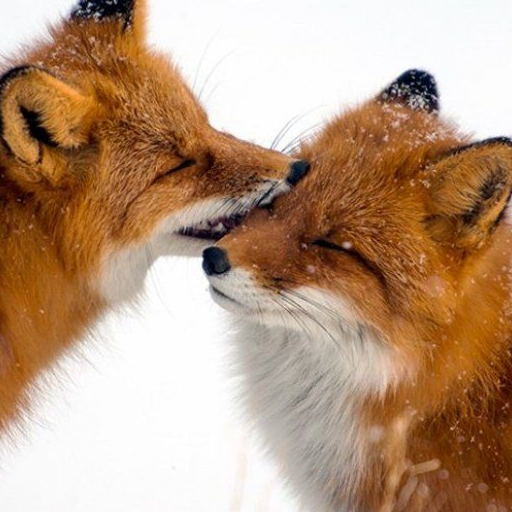

In [4]:
from PIL import Image
from io import BytesIO
import torchvision.transforms as T
import requests

URL="https://github.com/geronimi73/3090_shorts/blob/main/assets/3.jpg?raw=True"

image = Image.open(BytesIO(requests.get(URL).content))

# Crop a 512x512 image from the center
# AE downsizes image by factor 32 dc-ae-f32c32-sana-1.0-diffusers
# -> image dimensions must be a multiple of 32!
image = T.CenterCrop(512)(image)

print(image.size)
image

In [3]:
import torch
from diffusers import AutoencoderDC

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(
    "Efficient-Large-Model/Sana_600M_1024px_diffusers", 
    subfolder="vae", 
    torch_dtype=dtype
).to(device)

In [31]:
# Convert the image to a tensor and normalize mean and std.
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# convert, change dtype to bfloat16, and put on device 
latent = transform(image)[None].to(device).to(dtype)

# convert to latent
with torch.no_grad():
    latent = dcae.encode(latent).latent
latent.shape

torch.Size([1, 32, 16, 16])

In [48]:
[ 
    latent.min().item(),latent.max().item(), 
    latent.mean().item(), latent.std().item()
]

[-17.125, 11.0, 0.10107421875, 2.359375]

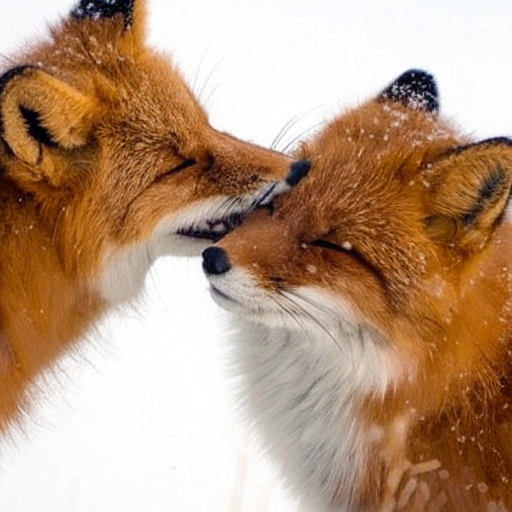

In [55]:
with torch.no_grad():
    image_roundtrip = dcae.decode(latent).sample.to("cpu")

# Normalize autoencoder output back to 0-1 and transform to image
image_roundtrip = torch.clamp_(image_roundtrip[0,:], -1, 1)
image_roundtrip = image_roundtrip * 0.5 + 0.5
image_roundtrip = T.ToPILImage()(image_roundtrip.float())
image_roundtrip

In [50]:
[ 
    image_out.min().item(),image_out.max().item(), 
    image_out.mean().item(), image_out.std().item()
]

[0.0, 1.0, 0.61328125, 0.330078125]

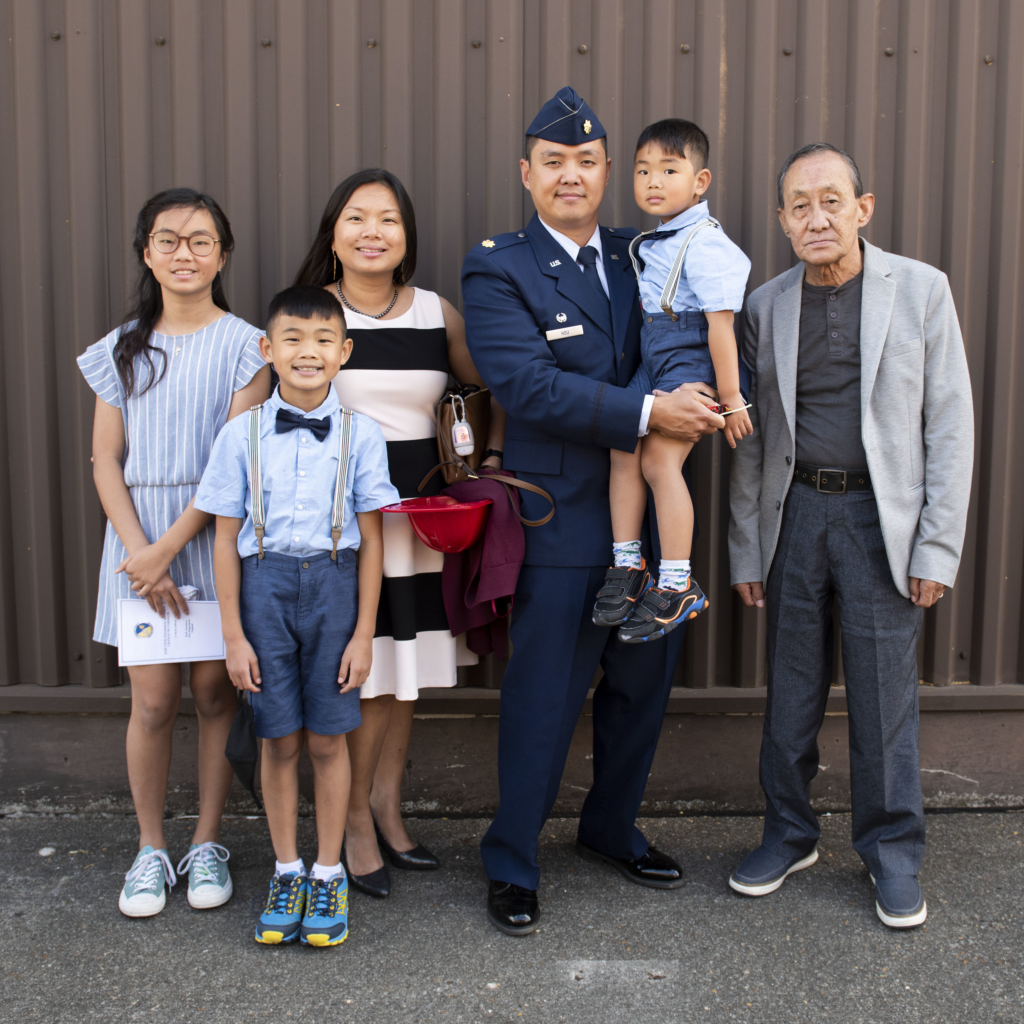

In [16]:
URL = "https://upload.wikimedia.org/wikipedia/commons/f/f2/423rd_CES_Change_of_Command_%286280000%29.jpg"

def load_image_from_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        return img
    else:
        raise Exception(f"Failed to load image from URL. Status code: {response.status_code}")

image = load_image_from_url(URL)
image = T.Resize(1024)(image)
image = T.CenterCrop(1024)(image)
image

In [17]:
# Convert the image to a tensor and normalize mean and std.
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# convert, change dtype to bfloat16, and put on device 
latent = transform(image)[None].to(device).to(dtype)

# convert to latent
with torch.no_grad():
    latent = dcae.encode(latent).latent
latent.shape

torch.Size([1, 32, 32, 32])

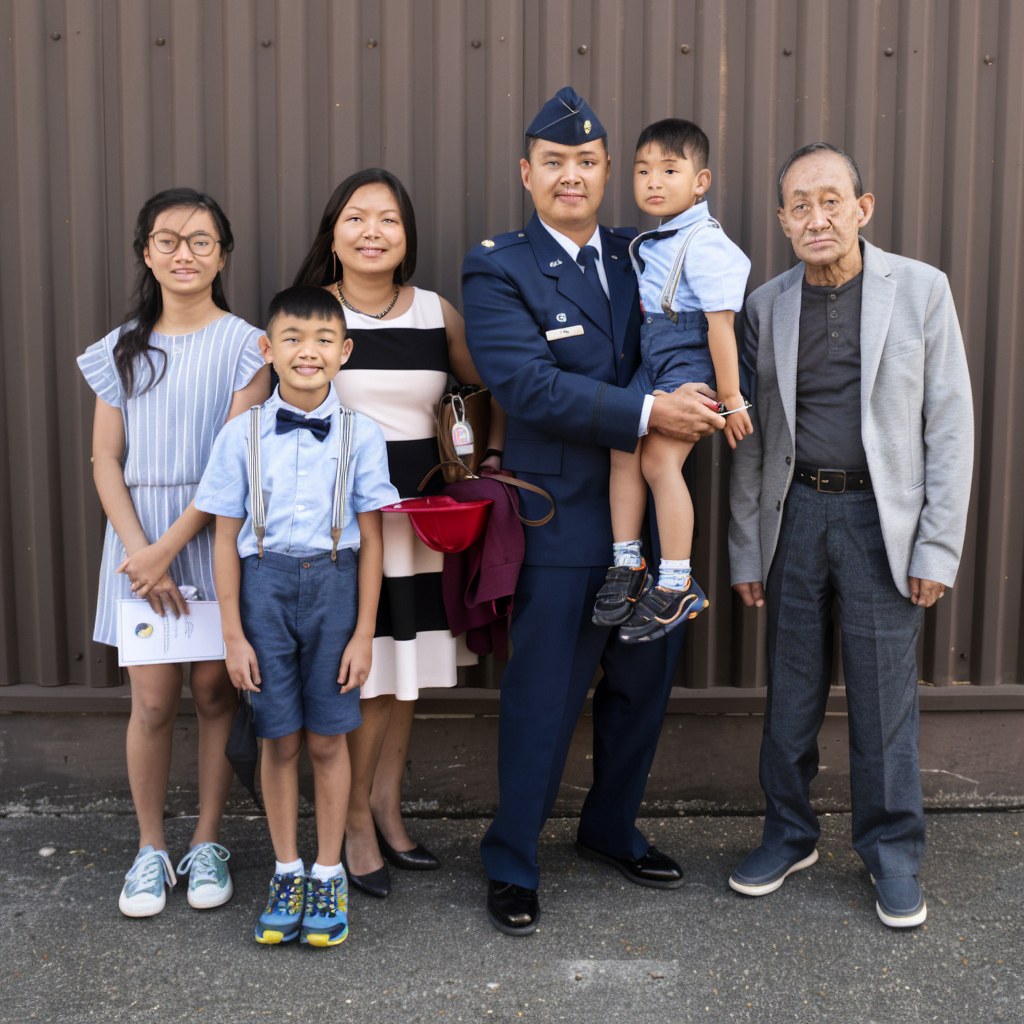

In [18]:
with torch.no_grad():
    image_roundtrip = dcae.decode(latent).sample.to("cpu")

# Normalize autoencoder output back to 0-1 and transform to image
image_roundtrip = torch.clamp_(image_roundtrip[0,:], -1, 1)
image_roundtrip = image_roundtrip * 0.5 + 0.5
image_roundtrip = T.ToPILImage()(image_roundtrip.float())
image_roundtrip